# 1.Sanitize the data and Discard irrelevant articles

In [ ]:
import pandas as pd
df_news_final_project = pd.read_parquet('https://storage.googleapis.com/msca-bdp-data-open/news_final_project/news_final_project.parquet', engine='pyarrow')
df_news_final_project.shape

(200083, 5)

In [ ]:
df_news_final_project

,url,date,language,title,text
0,http://businessnewsthisweek.com/business/infog...,2023-05-20,en,Infogain AI Business Solutions Now Available i...,\n\nInfogain AI Business Solutions Now Availab...
1,https://allafrica.com/stories/202504250184.html,2025-04-25,en,Africa: AI Policies in Africa - Lessons From G...,\nAfrica: AI Policies in Africa - Lessons From...
2,https://asiatimes.com/2023/07/yang-lan-intervi...,2023-07-25,en,Yang Lan interviews academics on AI developmen...,\nYang Lan interviews academics on AI developm...
3,https://cdn.meritalk.com/articles/commerce-nom...,2025-02-04,en,Commerce Nominee Promises Increased Domestic A...,\nCommerce Nominee Promises Increased Domestic...
4,https://citylife.capetown/hmn/uncategorized/re...,2023-11-11,en,Revolutionizing the Manufacturing Industry: Th...,Revolutionizing the Manufacturing Industry:...
...,...,...,...,...,...
200078,https://www.wuwf.org/2024-06-03/all-eyes-on-ra...,2024-06-03,en,‘All eyes on Rafah’ is the Internet's most vir...,\n‘All eyes on Rafah’ is the Internet's most v...
200079,https://www.zawya.com/en/press-release/compani...,2024-04-15,en,SentinelOne to spotlight Purple AI at GISEC 2024,SentinelOne to spotlight Purple AI at GISEC 20...
200080,https://www.zawya.com/en/press-release/governm...,2024-06-13,en,DGHR and DCAI join forces to support the world...,DGHR and DCAI join forces to support the world...
200081,https://zeenews.india.com/technology/samsung-g...,2024-09-29,en,Samsung Galaxy S24 FE Launched In India With A...,Samsung Galaxy S24 FE Launched In India With A...


### 1.1 Sanitize the data of web crawl remnants

In [ ]:
import re
from bs4 import BeautifulSoup

def clean_html(text):
    """Remove HTML tags using BeautifulSoup."""
    return BeautifulSoup(text, "html.parser").get_text()

def clean_text(text):
    """Sanitize text by removing crawl remnants, special characters, and empty metadata."""
    if not isinstance(text, str) or len(text) < 10:
        return ""

    text = clean_html(text)
    text = text.replace("\\n", "\n").replace("\\t", "\t")
    text = re.sub(r"\s+", " ", text)  # normalize whitespace
    text = re.sub(r"\[.*?\d{4}.*?\]", "", text)  # remove date brackets like [ May 20, 2023 ]
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # remove URLs
    text = re.sub(r"Read more.*", "", text, flags=re.IGNORECASE)
    text = re.sub(r"Click here.*", "", text, flags=re.IGNORECASE)
    return text.strip()

In [ ]:
import pandas as pd
from tqdm import tqdm

df = df_news_final_project
tqdm.pandas(desc="Sanitizing text")
df["text_cleaned"] = df["text"].progress_apply(clean_text)
df["title_cleaned"] = df["title"].progress_apply(clean_text)

Sanitizing text: 100%|██████████| 200083/200083 [00:10<00:00, 19474.35it/s]


In [ ]:
df['text_cleaned'][0]

'Infogain AI Business Solutions Now Available in the Microsoft Azure Marketplace | Business News This Week Business News  Courtyard by Marriott Mahabaleshwar Announces Three New Leadership Appointmen Business  Dibyendu Bhattacharya to appear in Sonu Sood’s Fateh and Anubhav Sinha’s next entertainment  Exclusive Interview with Mr. Subroto Sen, CEO, GenY Medium interview  NGEL and HMEL tie up to collaborate in Renewable Energy and the generation of Green Hydrogen & synthesizing Green Chemicals Business  Medica Group of Hospitals appoints Dr. Nandakumar Jairam as the new Chairman Health Home Business Entrepreneurship World Home Improvement interview Press Releases NewsVoir Business Wire Listing PR Newswire contact us Digital Marketing About Business News This Week Privacy Policy Search for: HomeBusinessInfogain AI Business Solutions Now Available in the Microsoft Azure Marketplace Infogain AI Business Solutions Now Available in the Microsoft Azure Marketplace May 20, 2023 Rekha Nair Busin

### 1.2 Discard irrelevant articles

In [ ]:
# Strong keywords for AI-specific articles
STRONG_KEYWORDS = [
    "artificial intelligence", "machine learning", "deep learning",
    "AI", "generative AI", "large language model", "LLM",
    "ChatGPT", "GPT-4", "OpenAI", "computer vision",
    "transformer model", "neural network", "AGI", "AIGC"
]

# Weak keywords that suggest potential relevance
WEAK_KEYWORDS = [
    "automation", "robot", "autonomous", "data science",
    "predictive analytics", "data mining", "big data",
    "natural language", "speech synthesis", "recommendation system",
    "smart", "AI-powered", "AI-driven", "data strategy"
]

# Known irrelevant topics
IRRELEVANT_TOPICS = [
    "celebrity", "fashion", "recipe", "travel blog",
    "horoscope", "astrology", "dating", "pet care"
]

def is_strongly_relevant(title, text):
    combined = (title + " " + text).lower()
    return any(keyword in combined for keyword in STRONG_KEYWORDS)

def is_weakly_relevant(title, text):
    combined = (title + " " + text).lower()
    count = sum(keyword in combined for keyword in WEAK_KEYWORDS)
    return count >= 2

def is_irrelevant(title, text):
    combined = (title + " " + text).lower()
    return any(topic in combined for topic in IRRELEVANT_TOPICS)

def should_keep_article(row):
    title = row.get("title", "")
    text = row.get("text", "")

    if is_strongly_relevant(title, text):
        return True
    if is_weakly_relevant(title, text) and not is_irrelevant(title, text):
        return True
    return False

In [ ]:
df_filtered = df[df.progress_apply(should_keep_article, axis=1)]

Sanitizing text: 100%|██████████| 200083/200083 [00:30<00:00, 6498.97it/s]


In [ ]:
df_filtered = df_filtered[
    (df_filtered["language"] == "en") &
    (df_filtered["text_cleaned"].str.len() > 200)
]

# 2.Detect major topics and draw connections to different industries / jobs

### 2.1 Detect major topics

In [ ]:
! pip install bertopic
! pip install transformers

In [ ]:
import pandas as pd
import torch
from bertopic import BERTopic
from sklearn.cluster import MiniBatchKMeans
from umap import UMAP
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from transformers import pipeline
import wandb
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

print("✅ GPU is available:", torch.cuda.is_available())

✅ GPU is available: True


In [ ]:
# Load cleaned + filtered news data
df_ai_news = df_filtered

# Concatenate title + body
df_ai_news["text_cleaned"] = df_ai_news["text_cleaned"].fillna("").astype(str)
df_ai_news["title_cleaned"] = df_ai_news["title_cleaned"].fillna("").astype(str)
df_ai_news["doc"] = df_ai_news["title_cleaned"] + ". " + df_ai_news["text_cleaned"]

documents = df_ai_news["doc"].tolist()

In [ ]:
# BERTopic
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

umap_model = UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.0,
    metric="cosine",
    random_state=42
)

kmeans_model = MiniBatchKMeans(
    n_clusters=30,
    batch_size=256,
    random_state=42
)

vectorizer_model = CountVectorizer(
    stop_words="english",
    ngram_range=(1, 2),
    max_df=0.95,
    min_df=5,
    max_features=7000,
    strip_accents="unicode",
    token_pattern=r"(?u)\b\w\w+\b"
)

topic_model = BERTopic(
    language="english",
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=kmeans_model,
    vectorizer_model=vectorizer_model,
    calculate_probabilities=False,
    verbose=True
)

topics, probs = topic_model.fit_transform(documents)
df_ai_news["topic"] = topics

2025-05-06 23:37:26,607 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/4616 [00:00<?, ?it/s]

2025-05-06 23:42:26,753 - BERTopic - Embedding - Completed ✓
2025-05-06 23:42:26,755 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-06 23:46:25,218 - BERTopic - Dimensionality - Completed ✓
2025-05-06 23:46:25,220 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-06 23:46:25,292 - BERTopic - Cluster - Completed ✓
2025-05-06 23:46:25,320 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-06 23:53:54,911 - BERTopic - Representation - Completed ✓


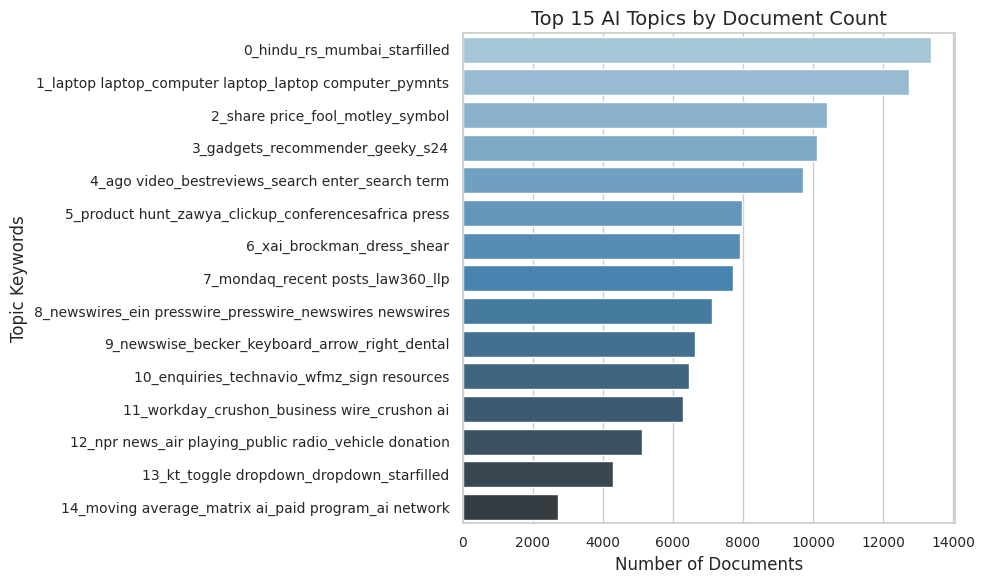

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

topic_info_clean = topic_model.get_topic_info()
topic_info_clean = topic_info_clean[topic_info_clean["Topic"] != -1].head(15)

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.barplot(
    y="Name",
    x="Count",
    data=topic_info_clean,
    palette="Blues_d"
)

plt.title("Top 15 AI Topics by Document Count", fontsize=14)
plt.xlabel("Number of Documents", fontsize=12)
plt.ylabel("Topic Keywords", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
output_path = "/content/drive/MyDrive/ai_news_project"
os.makedirs(output_path, exist_ok=True)

In [ ]:
topic_model.save(f"{output_path}/bertopic_model", serialization="pickle")

2025-05-06 23:54:59,258 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


In [ ]:
df_ai_news.to_parquet(f"{output_path}/news_cleaned_filtered.parquet", engine="pyarrow")

### 2.2 Industry Mapping

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
output_path = "/content/drive/MyDrive/ai_news_project"
# df_ai_news = pd.read_parquet(f"{output_path}/news_cleaned_filtered.parquet", engine="pyarrow")

In [ ]:
# zero-shot
from transformers import pipeline

classifier = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli",  # cross-encoder/nli-roberta-base
    device=0
)

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
# Industry
industry_labels = [
    "Finance", "Healthcare", "Retail", "Technology", "Media",
    "Education", "Transportation", "Manufacturing", "Legal",
    "Government", "Energy", "Agriculture"
]

# Job
job_labels = [
    "Data Scientist", "Software Engineer", "Doctor", "Nurse", "Journalist",
    "Teacher", "Lawyer", "Logistics Worker", "Marketing Manager",
    "AI Researcher", "Government Analyst", "Factory Worker"
]

In [ ]:
mapped_industries = []
mapped_jobs = []
topic_info = topic_model.get_topic_info()
for topic_id in tqdm(topic_info["Topic"][:30]):
    if topic_id == -1:
        mapped_industries.append("Other")
        mapped_jobs.append("Other")
        continue

    keywords = topic_model.get_topic(topic_id)
    input_text = "This topic is about " + ", ".join([w for w, _ in keywords])

    # Industry
    industry_result = classifier(input_text, industry_labels)
    top_industry = industry_result["labels"][0]
    mapped_industries.append(top_industry)

    # Job
    job_result = classifier(input_text, job_labels)
    top_job = job_result["labels"][0]
    mapped_jobs.append(top_job)

  0%|          | 0/30 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [ ]:
topic_info["Mapped_Industry"] = mapped_industries
topic_info["Mapped_Job"] = mapped_jobs

In [ ]:
topic_info

,Topic,Count,Name,Representation,Representative_Docs,Mapped_Industry,Mapped_Job
0,0,13378,0_hindu_rs_mumbai_starfilled,"[hindu, rs, mumbai, starfilled, bengaluru, ipl...","[Latest News | AI Integration with Cloud, Edge...",Media,Journalist
1,1,12738,1_laptop laptop_computer laptop_laptop compute...,"[laptop laptop, computer laptop, laptop comput...",[Musk to make xAI's Grok chatbot open-source a...,Technology,Doctor
2,2,10411,2_share price_fool_motley_symbol,"[share price, fool, motley, symbol, motley foo...",[History Says the Nasdaq Will Roar Higher in 2...,Media,Journalist
3,3,10122,3_gadgets_recommender_geeky_s24,"[gadgets, recommender, geeky, s24, windows 11,...",[Meta unveils more cautious approach to ChatGP...,Media,Doctor
4,4,9706,4_ago video_bestreviews_search enter_search term,"[ago video, bestreviews, search enter, search ...",[ChatGPT given the ability to talk | KNWA FOX2...,Media,AI Researcher
5,5,7975,5_product hunt_zawya_clickup_conferencesafrica...,"[product hunt, zawya, clickup, conferencesafri...","[Egypt, Italy to partner on AI centre in Cairo...",Media,Government Analyst
6,6,7921,6_xai_brockman_dress_shear,"[xai, brockman, dress, shear, cox, feed opens,...",[Walmart and other major companies seek to div...,Media,AI Researcher
7,7,7717,7_mondaq_recent posts_law360_llp,"[mondaq, recent posts, law360, llp, hashtag tr...",[USPTO And Copyright Office To Chart The Path ...,Media,Lawyer
8,8,7107,8_newswires_ein presswire_presswire_newswires ...,"[newswires, ein presswire, presswire, newswire...",[Casify Announces Waiting List for Its Groundb...,Media,Doctor
9,9,6633,9_newswise_becker_keyboard_arrow_right_dental,"[newswise, becker, keyboard_arrow_right, denta...",[Oral Medication for COVID-19 Discovered Using...,Media,Doctor


In [ ]:
topic_info.to_parquet(f"{output_path}/topic_info.parquet", engine="pyarrow")

#### not accurate enough, use GPT
Compared to traditional zero-shot models like BART-MNLI, I switched to GPT-based topic mapping for its superior language understanding and contextual inference. GPT-4 was able to interpret fragmented topic keywords and infer nuanced industry and job associations that better reflect real-world AI adoption scenarios. This improved both the diversity and accuracy of our topic-to-industry/job mapping, which forms the basis for later sentiment impact analysis.

In [ ]:
from bertopic import BERTopic
topic_model = BERTopic.load(f"{output_path}/bertopic_model")

In [ ]:
from openai import OpenAI
from tqdm import tqdm
import time

client = OpenAI(api_key="###")

def gpt_map_topics_to_industry_job(topic_model, topic_info, top_n=30):
    mapped_industries = []
    mapped_jobs = []

    print(f"🔍 Using GPT to classify top {top_n} topics...")

    for topic_id in tqdm(topic_info["Topic"][:top_n]):
        if topic_id == -1:
            mapped_industries.append("Other")
            mapped_jobs.append("Other")
            continue


        keywords = topic_model.get_topic(topic_id)
        keyword_list = [w for w, _ in keywords]
        input_keywords = ", ".join(keyword_list)

        prompt = f"""
You're an expert in analyzing AI-related industry topics.
Given the following top keywords extracted from news articles, please:

1. Determine the **most likely industry** these keywords belong to (such as Technology, Healthcare, Media, Education, etc.).
2. Identify **a typical job role** involved in this topic (such as Software Engineer, Data Scientist, Lawyer, Doctor, AI Researcher, etc.).

Output your response in **this format**:
Industry: <industry>
Job: <job>

Keywords:
{input_keywords}
"""

        try:
            response = client.chat.completions.create(
                model="gpt-4",
                messages=[{"role": "user", "content": prompt}],
                temperature=0
            )
            answer = response.choices[0].message.content.strip()

            industry_line = next((line for line in answer.splitlines() if line.startswith("Industry:")), "Industry: Other")
            job_line = next((line for line in answer.splitlines() if line.startswith("Job:")), "Job: Other")

            industry = industry_line.split("Industry:")[1].strip()
            job = job_line.split("Job:")[1].strip()

            mapped_industries.append(industry)
            mapped_jobs.append(job)

        except Exception as e:
            print(f"⚠️ GPT error on topic {topic_id}: {e}")
            mapped_industries.append("Other")
            mapped_jobs.append("Other")
            time.sleep(2)

    return mapped_industries, mapped_jobs

In [ ]:
mapped_industries, mapped_jobs = gpt_map_topics_to_industry_job(topic_model, topic_info, top_n=30)

topic_info["Mapped_Industry"] = mapped_industries
topic_info["Mapped_Job"] = mapped_jobs

🔍 Using GPT to classify top 30 topics...


100%|██████████| 30/30 [00:27<00:00,  1.07it/s]


In [ ]:
topic_info

,Topic,Count,Name,Representation,Representative_Docs,Mapped_Industry,Mapped_Job
0,0,13378,0_hindu_rs_mumbai_starfilled,"[hindu, rs, mumbai, starfilled, bengaluru, ipl...","[Latest News | AI Integration with Cloud, Edge...",Media/Sports,Sports Journalist
1,1,12738,1_laptop laptop_computer laptop_laptop compute...,"[laptop laptop, computer laptop, laptop comput...",[Musk to make xAI's Grok chatbot open-source a...,Technology,Computer Hardware Engineer
2,2,10411,2_share price_fool_motley_symbol,"[share price, fool, motley, symbol, motley foo...",[History Says the Nasdaq Will Roar Higher in 2...,Finance,Stock Market Analyst
3,3,10122,3_gadgets_recommender_geeky_s24,"[gadgets, recommender, geeky, s24, windows 11,...",[Meta unveils more cautious approach to ChatGP...,Technology,Software Engineer
4,4,9706,4_ago video_bestreviews_search enter_search term,"[ago video, bestreviews, search enter, search ...",[ChatGPT given the ability to talk | KNWA FOX2...,Media,Digital Content Producer
5,5,7975,5_product hunt_zawya_clickup_conferencesafrica...,"[product hunt, zawya, clickup, conferencesafri...","[Egypt, Italy to partner on AI centre in Cairo...",Technology,Product Manager
6,6,7921,6_xai_brockman_dress_shear,"[xai, brockman, dress, shear, cox, feed opens,...",[Walmart and other major companies seek to div...,Technology/Media,AI Researcher/Journalist
7,7,7717,7_mondaq_recent posts_law360_llp,"[mondaq, recent posts, law360, llp, hashtag tr...",[USPTO And Copyright Office To Chart The Path ...,Legal,Legal Advisor/Consultant
8,8,7107,8_newswires_ein presswire_presswire_newswires ...,"[newswires, ein presswire, presswire, newswire...",[Casify Announces Waiting List for Its Groundb...,Media,News Editor
9,9,6633,9_newswise_becker_keyboard_arrow_right_dental,"[newswise, becker, keyboard_arrow_right, denta...",[Oral Medication for COVID-19 Discovered Using...,Healthcare,Biomedical Researcher


In [ ]:
topic_info.to_parquet(f"{output_path}/topic_info.parquet", engine="pyarrow")

### 2.3 Overview

Using GPT-4, we mapped 30 topics (generated by BERTopic) to the most relevant **industries** and **job roles**, based on extracted topic keywords. This approach significantly outperforms earlier zero-shot classification by providing more nuanced and context-aware mappings.

### Industry Distribution

| Industry             | Approx. Topics | Notes |
|----------------------|----------------|-------|
| Technology           | 17+            | Covers AI, software, robotics, cloud, AR/VR |
| Media / News         | ~6             | Includes digital media, journalism, broadcasting |
| Finance              | 1              | Stock analysis, market insights |
| Healthcare           | 1              | Biomedical research focus |
| Legal                | 1              | Law and IP-related topics |
| Telecommunications   | 1              | Technical communication and networking topics |
| Entertainment        | 1              | Film/media production and cultural references |

### Job Role Distribution

| Job Category         | Example Roles                                | Coverage |
|----------------------|-----------------------------------------------|----------|
| Engineering / AI     | AI Researcher, Software Engineer, Cloud Architect | 12+   |
| Media / Content      | Journalist, News Editor, Radio Broadcaster    | 6+       |
| Product / Business   | Product Manager, Marketing Manager            | 2–3      |
| Data / Analytics     | Data Analyst, Stock Market Analyst            | 2        |
| Legal / Policy       | Legal Advisor, Government Analyst             | 2        |
| Emerging Tech        | AR/VR Developer, Audio Engineer               | 2+       |
| Healthcare           | Biomedical Researcher                         | 1        |


### Conclusion

GPT-based classification enabled a richer, more accurate mapping between AI-related topics and their real-world professional contexts. This mapping lays a strong foundation for downstream analysis, such as assessing AI adoption sentiment and impact across industries and roles.

In [ ]:
!pip install gradio

In [ ]:
import gradio as gr

def view_topic(topic_id: int):
    info = topic_info_dict.get(topic_id)
    if not info:
        return "❌ Invalid topic ID. Please select from the dropdown."

    keywords = [f"{w} ({round(score, 2)})" for w, score in info["keywords"][:10]]
    docs = df_ai_news[df_ai_news["topic"] == topic_id]["text_cleaned"].head(3).tolist()

    return [
        f"🧠 **Topic {topic_id}**",
        f"📈 **Documents:** {info['count']}",
        f"🏷️ **Industry:** {info['industry']}",
        f"👔 **Job Suggestion:** {info['job']}",
        f"🧾 **Top Keywords:**\n- " + "\n- ".join(keywords),
        f"📄 **Example Article 1:**\n\n{docs[0][:500]}..." if len(docs) > 0 else "",
        f"📄 **Example Article 2:**\n\n{docs[1][:500]}..." if len(docs) > 1 else "",
        f"📄 **Example Article 3:**\n\n{docs[2][:500]}..." if len(docs) > 2 else "",
    ]

topic_choices = [
    (f"Topic {int(row['Topic'])} - " + ", ".join([w for w, _ in topic_model.get_topic(int(row['Topic']))[:3]]), int(row['Topic']))
    for _, row in topic_info.iterrows() if row["Topic"] != -1
]

gr.Interface(
    fn=view_topic,
    inputs=gr.Dropdown(choices=topic_choices, label="Select Topic"),
    outputs=[
        gr.Markdown(label="Topic ID"),
        gr.Markdown(label="Document Count"),
        gr.Markdown(label="Industry"),
        gr.Markdown(label="Job Suggestion"),
        gr.Markdown(label="Top Keywords"),
        gr.Markdown(label="Example Article 1"),
        gr.Markdown(label="Example Article 2"),
        gr.Markdown(label="Example Article 3")
    ],
    title="🔍 Explore AI Topics: Industry & Job Mapping",
    description="Use the dropdown to explore topics discovered by BERTopic and mapped to industries and jobs via Zero-Shot classification."
).launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f9f3bb3e7a14afeab2.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# 3.Identify top industries / job that experienced successful or unsuccessful AI integration

### Advantages of Using GPT-Labeled Data vs. External Labeled Datasets

#### 1. Domain-Specific Relevance
External datasets (e.g., IMDb, SST) are based on movie or product reviews and do not match the professional language or content of AI news.
GPT-labeled data is generated from your actual news corpus, ensuring domain alignment with your task.

#### 2. Task-Aligned Sentiment Labels
Traditional datasets focus on general sentiment (positive/negative).
Your task requires classifying the *impact* of AI (e.g., successful vs. failed applications), which GPT can be prompted to recognize explicitly.

#### 3. Consistent Labeling Format
GPT provides uniform label outputs (e.g., "Positive", "Neutral", "Negative") based on clear instructions.
Public datasets may vary in labeling style or include noisy, user-generated content.

#### 4. Flexible and Customizable Prompts
GPT prompts can be tailored for different tasks, such as 2-class or 3-class sentiment, or role-specific judgments (e.g., policy, technical).
You can easily refine labeling criteria without re-annotating manually.

#### 5. Better Model Adaptation
RoBERTa fine-tuned on GPT-labeled data benefits from inputs with the same tone, structure, and terminology as the target inference set.
This improves convergence and generalization for domain-specific applications.

#### Summary
Using GPT-labeled data provides a more accurate, consistent, and domain-adapted foundation for fine-tuning, enabling your sentiment analysis model to perform more effectively on AI-related news content.

In [ ]:
from openai import OpenAI
import pandas as pd
from tqdm import tqdm

client = OpenAI(api_key="###")

df_sample = df_ai_news.sample(n=500, random_state=42).reset_index(drop=True)
labels = []

def label_with_gpt(text):
    prompt = f"""
    You're an expert analyst. Please classify the sentiment of the following news article content about AI application.

    Text:
    \"\"\"{text}\"\"\"

    Is the tone of this news content:
    - Positive (reflecting successful or beneficial AI application),
    - Neutral (no clear success or failure),
    - or Negative (reflecting failed or harmful AI impact)?

    Just respond with one word: Positive, Neutral, or Negative.
    """

    try:
        response = client.chat.completions.create(
            model="gpt-4",
            messages=[{"role": "user", "content": prompt}],
            temperature=0
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print("Error:", e)
        return "Neutral"

# 开始标注
for i in tqdm(range(len(df_sample))):
    label = label_with_gpt(df_sample.loc[i, "text_cleaned"][:1000])
    labels.append(label)

df_sample["gpt_sentiment"] = labels
df_sample = df_sample[df_sample["gpt_sentiment"].isin(["Positive", "Negative"])]  # 去掉 Neutral
df_sample["label"] = df_sample["gpt_sentiment"].map({"Positive": 1, "Negative": 0})
df_sample.to_csv("gpt_labeled_data.csv", index=False)

100%|██████████| 500/500 [14:16<00:00,  1.71s/it]


In [ ]:
! pip install datasets

In [ ]:
import wandb
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

wandb.init(project="ai-sentiment-training")
df_labeled = pd.read_csv("gpt_labeled_data.csv")
dataset = Dataset.from_pandas(df_labeled[["text_cleaned", "label"]])

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def tokenize(batch):
    return tokenizer(batch["text_cleaned"], truncation=True, padding="max_length")

tokenized = dataset.map(tokenize, batched=True)
tokenized = tokenized.rename_column("label", "labels")
tokenized.set_format("torch", columns=["input_ids", "attention_mask", "labels"])


model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    logging_dir="./logs",
    report_to="wandb"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized,
    eval_dataset=tokenized.select(range(50)),
    tokenizer=tokenizer
)

trainer.train()
model.save_pretrained("sentiment_roberta")
tokenizer.save_pretrained("sentiment_roberta")

Map:   0%|          | 0/131 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss
1,No log,0.756202
2,No log,0.284308
3,No log,0.217000


('sentiment_roberta/tokenizer_config.json',
 'sentiment_roberta/special_tokens_map.json',
 'sentiment_roberta/vocab.json',
 'sentiment_roberta/merges.txt',
 'sentiment_roberta/added_tokens.json')

In [ ]:
from tqdm import tqdm
import pandas as pd

def batched_sentiment_prediction(df, text_col, pipe, batch_size=32, save_every=10000):
    results = []
    texts = df[text_col].tolist()

    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size]
        try:
            preds = pipe(batch, truncation=True)
            labels = [r["label"] for r in preds]
            results.extend(labels)
        except Exception as e:
            print(f"⚠️ Batch {i}-{i+batch_size} failed: {e}")
            results.extend(["LABEL_0"] * len(batch))

        if (i // batch_size) % (save_every // batch_size) == 0 and i > 0:
            temp_df = df.iloc[:len(results)].copy()
            temp_df["sentiment_label"] = results
            temp_df["sentiment"] = temp_df["sentiment_label"].map({"LABEL_1": 1, "LABEL_0": -1})
            temp_df.to_parquet(f"{output_path}/ai_sentiment_checkpoint_{i}.parquet", index=False)
            print(f"✅ Saved checkpoint at row {i}.")

    return results

In [ ]:
from transformers import TextClassificationPipeline

pipe = TextClassificationPipeline(
    model=model,
    tokenizer=tokenizer,
    device=0,
    return_all_scores=False,
    truncation=True
)


df_ai_news = df_ai_news.reset_index(drop=True)
pred_labels = batched_sentiment_prediction(df_ai_news, text_col="text_cleaned", pipe=pipe, batch_size=32)

df_ai_news["sentiment_label"] = pred_labels
df_ai_news["sentiment"] = df_ai_news["sentiment_label"].map({"LABEL_1": 1, "LABEL_0": -1})

df_ai_news.to_parquet(f"{output_path}/ai_sentiment_final.parquet", index=False)
print("✅ Final sentiment prediction saved!")

Device set to use cuda:0
  7%|▋         | 313/4616 [03:35<1:35:36,  1.33s/it]

✅ Saved checkpoint at row 9984.


 14%|█▎        | 625/4616 [07:24<2:00:34,  1.81s/it]

✅ Saved checkpoint at row 19968.


 20%|██        | 937/4616 [11:12<2:23:35,  2.34s/it]

✅ Saved checkpoint at row 29952.


 27%|██▋       | 1249/4616 [15:02<2:34:11,  2.75s/it]

✅ Saved checkpoint at row 39936.


 34%|███▍      | 1561/4616 [18:52<2:46:18,  3.27s/it]

✅ Saved checkpoint at row 49920.


 41%|████      | 1873/4616 [22:44<2:56:14,  3.86s/it]

✅ Saved checkpoint at row 59904.


 47%|████▋     | 2185/4616 [26:39<2:52:02,  4.25s/it]

✅ Saved checkpoint at row 69888.


 54%|█████▍    | 2497/4616 [30:34<2:46:38,  4.72s/it]

✅ Saved checkpoint at row 79872.


 61%|██████    | 2809/4616 [34:34<2:53:58,  5.78s/it]

✅ Saved checkpoint at row 89856.


 68%|██████▊   | 3121/4616 [38:33<2:21:44,  5.69s/it]

✅ Saved checkpoint at row 99840.


 74%|███████▍  | 3433/4616 [42:32<2:06:38,  6.42s/it]

✅ Saved checkpoint at row 109824.


 81%|████████  | 3745/4616 [46:33<1:40:10,  6.90s/it]

✅ Saved checkpoint at row 119808.


 88%|████████▊ | 4057/4616 [50:36<1:09:51,  7.50s/it]

✅ Saved checkpoint at row 129792.


 95%|█████████▍| 4369/4616 [54:32<31:14,  7.59s/it]

✅ Saved checkpoint at row 139776.


100%|██████████| 4616/4616 [57:19<00:00,  1.34it/s]


✅ Final sentiment prediction saved!


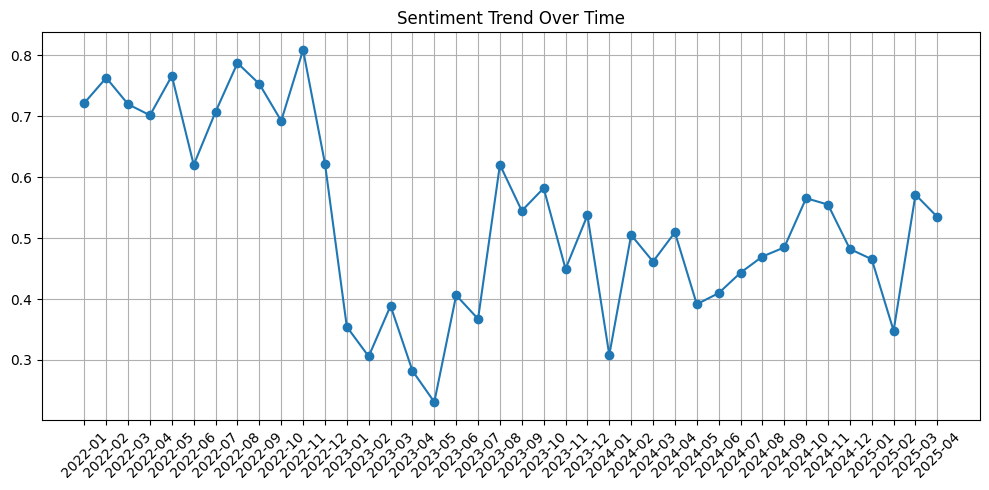

In [ ]:
df_ai_news["date"] = pd.to_datetime(df_ai_news["date"])
df_ai_news["month"] = df_ai_news["date"].dt.to_period("M")
trend = df_ai_news.groupby("month")["sentiment"].mean().reset_index()

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(trend["month"].astype(str), trend["sentiment"], marker="o")
plt.title("Sentiment Trend Over Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
df_ai_news = df_ai_news.merge(
    topic_info[["Topic", "Mapped_Industry", "Mapped_Job"]],
    how="left",
    left_on="topic",
    right_on="Topic"
)

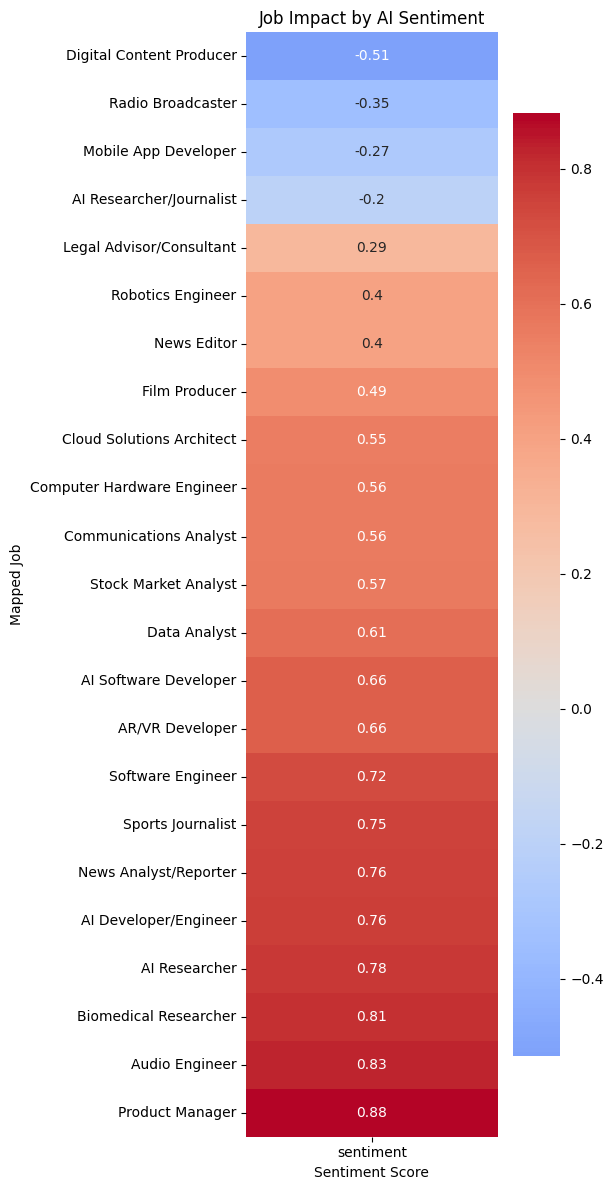

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

job_impact = df_ai_news.groupby("Mapped_Job")["sentiment"].mean().sort_values()

plt.figure(figsize=(6, 12))
sns.heatmap(job_impact.to_frame(), annot=True, cmap="coolwarm", center=0)

plt.title("Job Impact by AI Sentiment")
plt.xlabel("Sentiment Score")
plt.ylabel("Mapped Job")
plt.tight_layout()
plt.show()

### Interpretation of Job-Level Sentiment Impact from AI

Based on the sentiment heatmap of job roles, I observe significant differences in how AI is perceived to impact various professions. These differences are influenced by the nature of the work, the degree of automation risk, and how AI augments versus replaces human tasks.

#### **1.Jobs with High Positive Sentiment**

Examples: **Product Manager, Audio Engineer, AI Researcher, Biomedical Researcher**

These roles scored highly (above 0.75), suggesting that AI is seen as a value-adding tool.

**Reasons:**
These jobs are inherently innovative and benefit from AI-enhanced productivity, such as automated data processing or simulation tools.
AI serves as an assistant rather than a replacement—e.g., AI researchers develop the very tools they use.
Roles like Biomedical Researcher leverage AI in discovery processes, accelerating outcomes without diminishing human expertise.

#### **2.Jobs with Lower or Negative Sentiment**

Examples: **Digital Content Producer, Radio Broadcaster, Mobile App Developer, Journalist**

These roles showed lower average sentiment scores, with some even in the negative range.

**Reasons:**
High automation risk: Tasks in content production and broadcasting are increasingly handled by generative models (e.g., synthetic speech, AI-written news).
Competition from AI-generated content: Journalistic roles face potential displacement as AI improves at summarization, reporting, and narrative generation.
Trust and quality concerns: Media jobs are more sensitive to AI hallucinations or misinformation, increasing public skepticism.

#### Summary

| More Positively Impacted Roles      | Explanation                                              |
|-------------------------------------|----------------------------------------------------------|
| AI Researcher / Developer           | Co-evolve with AI, growing in strategic importance       |
| Product Manager / Technical Leader  | Use AI to augment efficiency and strategic insights      |
| Biomedical Researcher               | AI accelerates discovery without replacing expertise     |

| More Negatively Impacted Roles      | Explanation                                              |
|-------------------------------------|----------------------------------------------------------|
| Content Creators / Journalists      | Vulnerable to content automation and credibility issues  |
| Broadcasters / App Developers       | Risk of displacement by generative tools and copilots    |
| Legal/Media Assistants              | Process standardization reduces human differentiation    |

This analysis suggests that the perception of AI’s impact on jobs is closely tied to whether AI is seen as a collaborator or a competitor in the professional workflow.

# 4.Identify technologies and AI solutions that might be affecting the employment landscape

In [ ]:
from collections import defaultdict

tech_keywords = [
    # Foundation Models
    "ChatGPT", "GPT-4", "GPT-3.5", "Claude", "Gemini", "Bard", "LLaMA", "Mistral", "Sora",
    # Tools and Frameworks
    "LangChain", "AutoGPT", "Agent", "RAG", "Vector Database", "Pinecone", "Weaviate",
    # Development tools & platforms
    "Copilot", "Notion AI", "Midjourney", "DALL·E", "Stable Diffusion", "Hugging Face",
    # Technical Concepts
    "Transformer", "Self-Attention", "LoRA", "Fine-tuning", "RLHF", "DPO", "Tokenization",
    # Application Areas
    "AutoML", "RPA", "AI Ethics", "AI Regulation", "Synthetic Data", "Prompt Engineering",
    # Companies and Organizations
    "OpenAI", "Anthropic", "Meta AI", "Google DeepMind", "Microsoft AI", "Stability AI"
]

df_news_timeline = df_ai_news.copy()
df_news_timeline["month"] = pd.to_datetime(df_news_timeline["date"]).dt.to_period("M").astype(str)

keyword_month_counts = defaultdict(lambda: defaultdict(int))

for _, row in df_news_timeline.iterrows():
    text = row["text_cleaned"].lower()
    month = row["month"]
    for keyword in tech_keywords:
        if keyword.lower() in text:
            keyword_month_counts[keyword][month] += 1

tech_timeline_df = pd.DataFrame(keyword_month_counts).fillna(0).T
tech_timeline_df = tech_timeline_df.sort_index(axis=1)  # Sort columns by time
tech_timeline_df = tech_timeline_df.loc[tech_timeline_df.sum(axis=1) > 0]  # Remove unused keywords



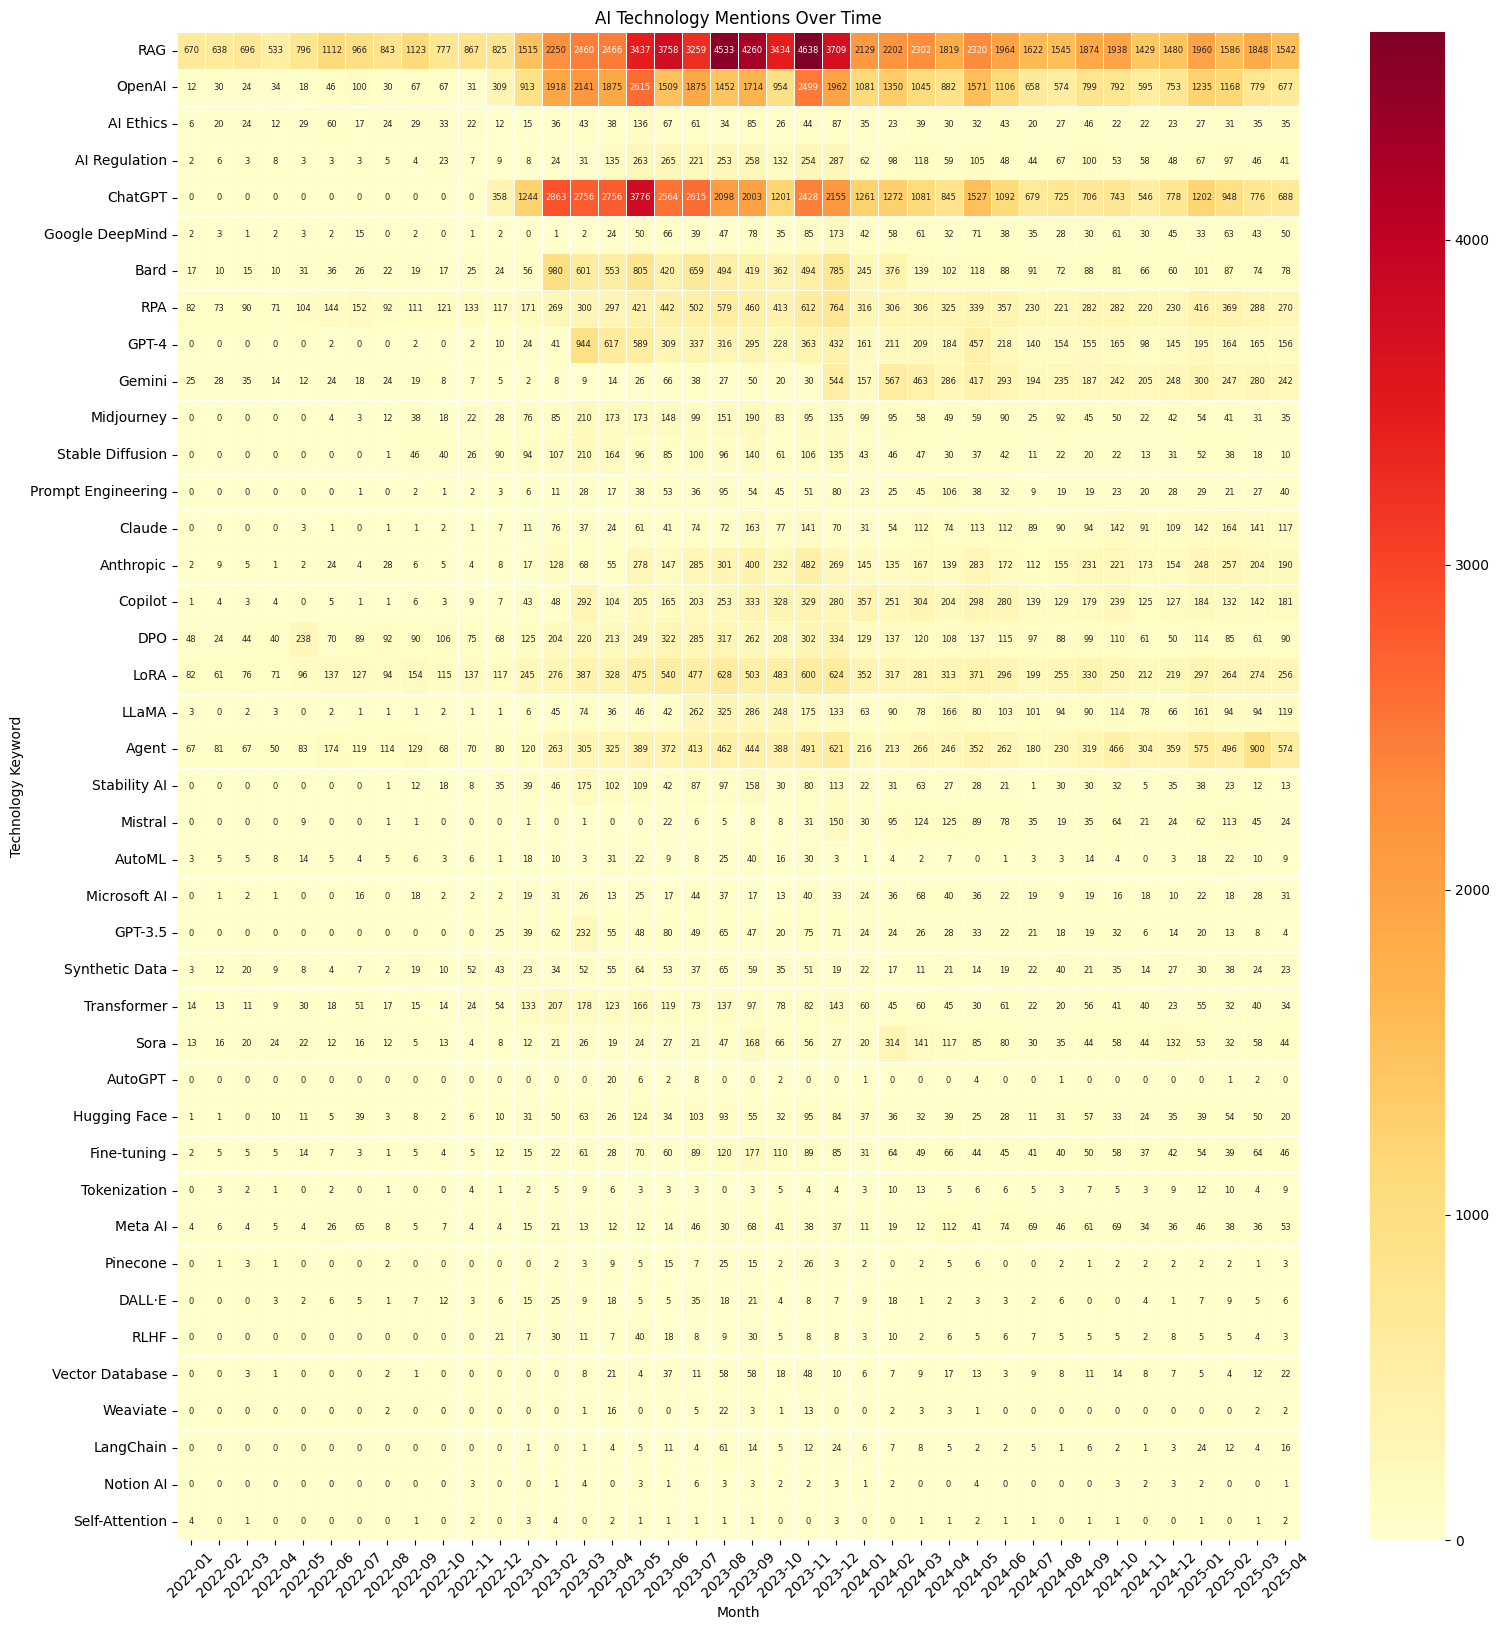

In [ ]:
plt.figure(figsize=(16, max(6, 0.4 * len(tech_timeline_df))))
sns.heatmap(
    tech_timeline_df,
    cmap="YlOrRd",
    annot=True,
    fmt=".0f",
    annot_kws={"size": 6},  # ✅ Smaller font size
    linewidths=0.5
)
plt.title("AI Technology Mentions Over Time")
plt.xlabel("Month")
plt.ylabel("Technology Keyword")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Summary of "AI Technology Mentions Over Time" Heatmap

This heatmap visualizes how frequently various AI technologies were mentioned in news articles from early 2022 to early 2025. The x-axis represents time by month, while the y-axis lists AI-related keywords. Darker colors indicate higher mention frequency.

#### Key Insights

#### 1. Dominant Technologies: ChatGPT, RAG, OpenAI
- **ChatGPT** shows a major surge starting in late 2022, sustaining high attention throughout 2023 and beyond.
- **RAG (Retrieval-Augmented Generation)** sees strong growth in 2023–2024, indicating rising interest in enterprise-level LLM integration.
- **OpenAI** is persistently mentioned, reflecting its central role in the ecosystem.

#### 2. Model Launch Waves
- **GPT-4** peaked in mentions after its March 2023 release.
- Competitors like **Claude, Gemini, Bard, Anthropic**, and **Google DeepMind** rise throughout 2023–2024.
- **Sora**, OpenAI’s video model, becomes prominent in early 2024.

#### 3. Technical Ecosystem Expansion
- Mentions of **LoRA, DPO, RLHF, Fine-tuning, Prompt Engineering** increased, showing that discussions are shifting from product to technique.
- Tools like **LangChain, AutoGPT, Vector Database** gained traction among developers.

#### 4. Regulation and Ethics Awareness
- Keywords like **AI Ethics** and **AI Regulation** show steady growth starting mid-2023, signaling growing concern over safety and policy.

#### Conclusion
The heatmap illustrates a clear trajectory: from attention on landmark model releases (e.g., ChatGPT, GPT-4) in 2022–2023 to broader ecosystem development and governance concerns by 2024. This reflects a maturing AI landscape moving from hype to integration and accountability.

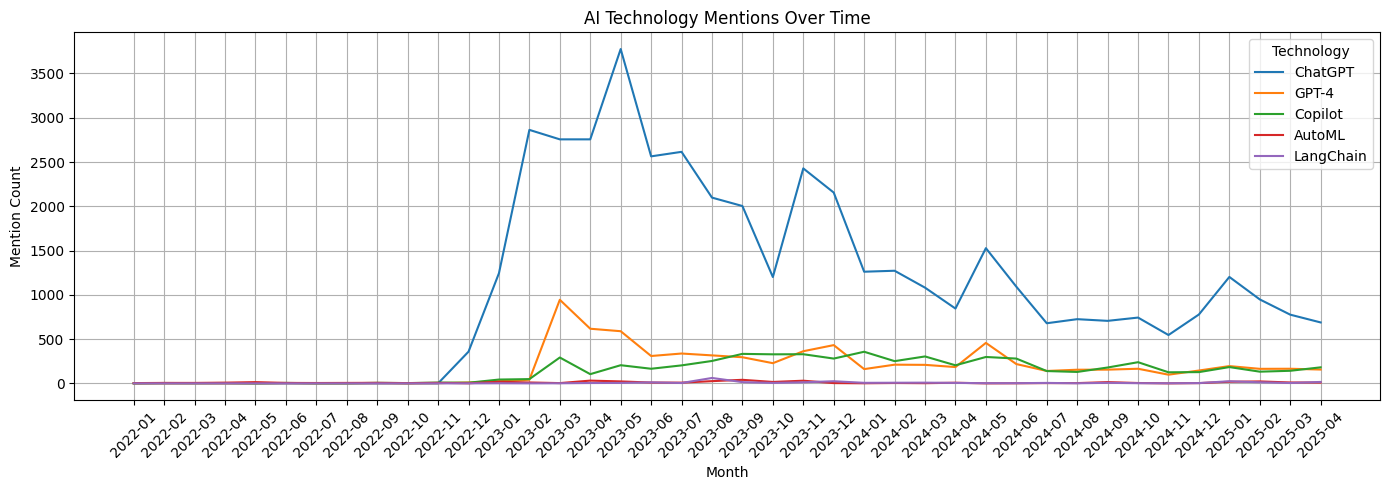

In [ ]:
# Define a small set of keywords for line plot
selected_keywords = ["ChatGPT", "GPT-4", "Copilot", "AutoML", "LangChain"]

# Filter the timeline data
tech_selected_df = tech_timeline_df.loc[selected_keywords].T  # Transpose to time → keyword

# Plot line chart
plt.figure(figsize=(14, 5))
for keyword in selected_keywords:
    sns.lineplot(data=tech_selected_df, x=tech_selected_df.index, y=keyword, label=keyword)

plt.title("AI Technology Mentions Over Time")
plt.xlabel("Month")
plt.ylabel("Mention Count")
plt.xticks(rotation=45)
plt.legend(title="Technology")
plt.grid(True)
plt.tight_layout()
plt.show()

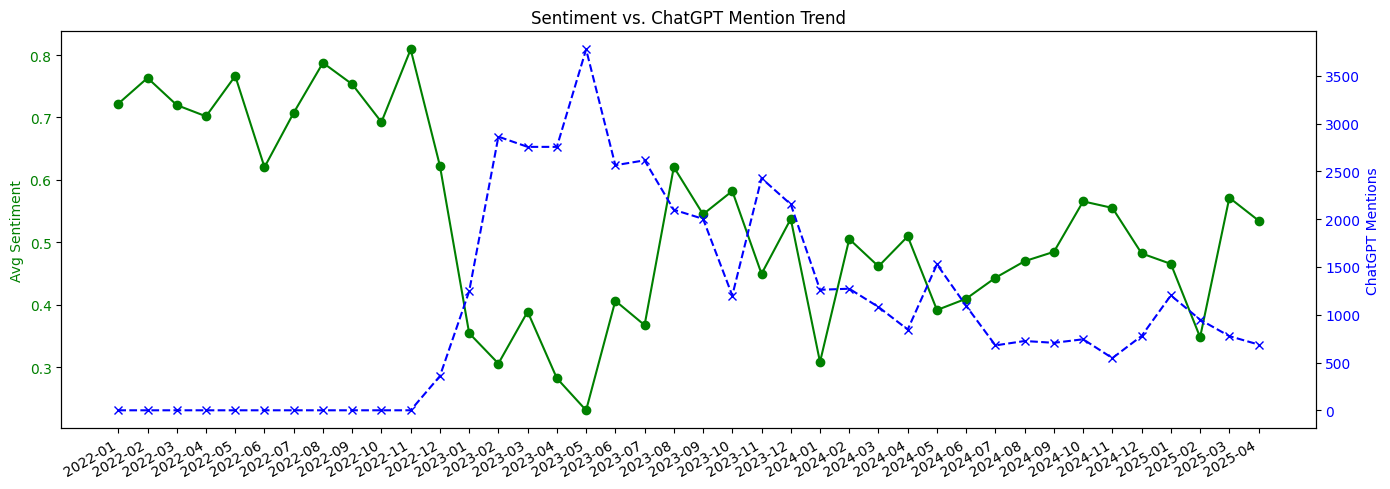

In [ ]:
fig, ax1 = plt.subplots(figsize=(14, 5))

# Plot sentiment
ax1.plot(sentiment_trend.index, sentiment_trend.values, color="green", marker="o", label="Sentiment")
ax1.set_ylabel("Avg Sentiment", color="green")
ax1.tick_params(axis='y', labelcolor="green")

# Plot one tech keyword on secondary axis
ax2 = ax1.twinx()
ax2.plot(tech_selected_df.index, tech_selected_df["ChatGPT"], color="blue", linestyle="--", marker="x", label="ChatGPT Mentions")
ax2.set_ylabel("ChatGPT Mentions", color="blue")
ax2.tick_params(axis='y', labelcolor="blue")

plt.title("Sentiment vs. ChatGPT Mention Trend")
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

### Summary: Sentiment vs. ChatGPT Mention Trend

This dual-axis line chart illustrates the relationship between public sentiment in AI-related news and the frequency of "ChatGPT" mentions from January 2022 to April 2025.

#### Key Observations

- **ChatGPT Mentions Surge (Late 2022 – Early 2023)**  
  Mentions of ChatGPT began to rise sharply after its public release in November 2022, peaking around early-to-mid 2023.

- **Inverse Sentiment Shift**  
  As mentions of ChatGPT increased, average sentiment in AI news dropped significantly. This suggests growing public scrutiny, debate, or concern about its societal impact.

- **Stabilization Period (2024 onward)**  
  After the peak, mentions began to decline, while sentiment gradually recovered and stabilized, possibly indicating adaptation and normalization of ChatGPT in media narratives.

#### Interpretation

The trend indicates that **initial hype and media saturation around ChatGPT were associated with more cautious or negative sentiment**, likely due to concerns around misinformation, job disruption, or ethical risks. Over time, as the novelty wore off and governance efforts improved, sentiment became more balanced.

This suggests that **public perception of AI tools like ChatGPT is not just shaped by technological performance but also by social, regulatory, and ethical discourse.**

In [ ]:
import pandas as pd
df_ai_news = pd.read_parquet(f"{output_path}/ai_sentiment_final.parquet", engine="pyarrow")
topic_info = pd.read_parquet(f"{output_path}/topic_info.parquet", engine="pyarrow")

#  5.Identify organizations, people, and locations. Then, apply sentiment analysis

### Why I Use `Jean-Baptiste/roberta-large-ner-english` Without Further Fine-Tuning

After experimentation, I decided to use the pre-trained `Jean-Baptiste/roberta-large-ner-english` model directly for our Named Entity Recognition (NER) task, instead of fine-tuning it with GPT-labeled data. The main reasons are:

1. **Insufficient Labeled Data**
   - The GPT-labeled dataset was relatively small (only dozens to a few hundred examples).
   - Fine-tuning with such limited data led to catastrophic forgetting, where the model lost its general NER capability.

2. **Label Noise in GPT Output**
   - GPT-generated annotations often contain inconsistencies, partial entities, or incorrect BIO formats.
   - These noisy labels introduce harmful bias during fine-tuning, degrading the model’s performance.

3. **High Cost and Latency**
   - GPT-based NER labeling is both slow and expensive when applied to large-scale datasets.
   - It is impractical to generate high-quality annotations at scale with GPT-4 due to time and API cost constraints.

4. **Strong Baseline Performance**
   - `Jean-Baptiste/roberta-large-ner-english` is already fine-tuned on CoNLL-2003 and performs robustly across standard NER domains.
   - For our use case (news-based entity extraction), it provides strong out-of-the-box accuracy and consistency.

As a result, I adopt the pre-trained model directly, avoiding the risks and costs of imperfect fine-tuning.

In [ ]:
import wandb

wandb.init(project="ai-ner-investment-tracking", name="ner-with-percentage")

total_rows = len(df_ai_news)
processed_rows = 0

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: easonwangzk (easonwangzk-the-university-of-chicago) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline

model_name = "Jean-Baptiste/roberta-large-ner-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple", device=0)

Device set to use cuda:0


In [ ]:
import time

def extract_entities_with_tracking(text, idx):
    global processed_rows

    # Handle empty or invalid text
    if not isinstance(text, str) or len(text.strip()) < 5:
        return [], [], []

    start = time.time()
    try:
        # Ensure aggregation is set in pipeline definition, not here
        entities = ner_pipeline(text[:512])
    except Exception as e:
        wandb.log({"ner_error": 1})
        return [], [], []

    duration = time.time() - start

    # Raw extraction
    orgs = [e["word"] for e in entities if e["entity_group"] == "ORG"]
    persons = [e["word"] for e in entities if e["entity_group"] == "PER"]
    locations = [e["word"] for e in entities if e["entity_group"] in ["LOC", "GPE"]]

    # Clean up function
    def clean(entity_list):
        return list(set([e for e in entity_list if len(e) > 2 and not e.startswith("##")]))

    orgs = clean(orgs)
    persons = clean(persons)
    locations = clean(locations)

    # Progress update
    processed_rows += 1
    percent_complete = round(processed_rows / total_rows * 100, 2)

    # wandb logging
    wandb.log({
        "ner_runtime_sec": duration,
        "num_orgs": len(orgs),
        "num_persons": len(persons),
        "num_locations": len(locations),
        "progress_percent": percent_complete,
        "processed_rows": processed_rows
    })

    return orgs, persons, locations

In [ ]:
from tqdm import tqdm
tqdm.pandas()

df_ner = df_ai_news.copy()

results = [extract_entities_with_tracking(text, idx) for idx, text in tqdm(enumerate(df_ner["text_cleaned"]), total=10)]

results_df = pd.DataFrame(results, columns=["ORGs", "PERSONs", "LOCs"])

# Combine with original
df_ner = pd.concat([df_ner, results_df], axis=1)

147687it [59:28, 41.38it/s]


In [4]:
df_ner

,url,date,language,title,text,text_cleaned,title_cleaned,doc,topic,sentiment_label,sentiment,ORGs,PERSONs,LOCs
0,http://businessnewsthisweek.com/business/infog...,2023-05-20,en,Infogain AI Business Solutions Now Available i...,\n\nInfogain AI Business Solutions Now Availab...,Infogain AI Business Solutions Now Available i...,Infogain AI Business Solutions Now Available i...,Infogain AI Business Solutions Now Available i...,1,LABEL_1,1,"[ GenY, Courtyard by Marriott Mahabaleshwar, ...","[ Fateh, Anubhav Sinha, Dibyendu Bhattachary...",[]
1,https://allafrica.com/stories/202504250184.html,2025-04-25,en,Africa: AI Policies in Africa - Lessons From G...,\nAfrica: AI Policies in Africa - Lessons From...,Africa: AI Policies in Africa - Lessons From G...,Africa: AI Policies in Africa - Lessons From G...,Africa: AI Policies in Africa - Lessons From G...,0,LABEL_1,1,"[ allAfrica, All, The Conversation Africa, ...",[ Thompson Gyedu Kwarkye],"[Johannesburg, Rwanda, Ghana, Africa]"
2,https://asiatimes.com/2023/07/yang-lan-intervi...,2023-07-25,en,Yang Lan interviews academics on AI developmen...,\nYang Lan interviews academics on AI developm...,Yang Lan interviews academics on AI developmen...,Yang Lan interviews academics on AI developmen...,Yang Lan interviews academics on AI developmen...,2,LABEL_1,1,"[ Asia Times, LinkedIn]","[ Yang Lan, Trump]","[ Philippines Southeast Asia, Asia, China Bu..."
3,https://cdn.meritalk.com/articles/commerce-nom...,2025-02-04,en,Commerce Nominee Promises Increased Domestic A...,\nCommerce Nominee Promises Increased Domestic...,Commerce Nominee Promises Increased Domestic A...,Commerce Nominee Promises Increased Domestic A...,Commerce Nominee Promises Increased Domestic A...,7,LABEL_1,1,"[ AI, Commerce, LinkedIn Twitter, Departmen...","[ Howard Lutnick, Donald Trump, Andrew Rice]",[]
4,https://citylife.capetown/hmn/uncategorized/re...,2023-11-11,en,Revolutionizing the Manufacturing Industry: Th...,Revolutionizing the Manufacturing Industry:...,Revolutionizing the Manufacturing Industry: Th...,Revolutionizing the Manufacturing Industry: Th...,Revolutionizing the Manufacturing Industry: Th...,0,LABEL_1,1,"[ Hla mus rau cov ntsiab lus, SpacetechnologyS...",[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147682,https://www.wkyt.com/prnewswire/2023/09/21/cha...,2023-09-21,en,"Chano Fernandez Joins Eightfold AI as Co-CEO, ...","Chano Fernandez Joins Eightfold AI as Co-CEO, ...","Chano Fernandez Joins Eightfold AI as Co-CEO, ...","Chano Fernandez Joins Eightfold AI as Co-CEO, ...","Chano Fernandez Joins Eightfold AI as Co-CEO, ...",14,LABEL_1,1,"[ Health DivideWKYT, Kentucky Newsmakers, WKYT...",[ Chano Fernandez],"[ Jude, Kentucky]"
147683,https://www.wncw.org/2024-11-16/biden-and-xi-t...,2024-11-17,en,Biden and Xi take a first step to limit AI and...,\n\nBiden and Xi take a first step to limit AI...,Biden and Xi take a first step to limit AI and...,Biden and Xi take a first step to limit AI and...,Biden and Xi take a first step to limit AI and...,12,LABEL_0,-1,[ WNCW],"[ Biden, Xi]",[]
147684,https://www.wndu.com/prnewswire/2023/11/15/woo...,2023-11-15,en,Woolpert and Allvision Forge Strategic Agreeme...,Woolpert and Allvision Forge Strategic Agreeme...,Woolpert and Allvision Forge Strategic Agreeme...,Woolpert and Allvision Forge Strategic Agreeme...,Woolpert and Allvision Forge Strategic Agreeme...,11,LABEL_1,1,"[En Español, SportsNotre DameEn Español, Wool...",[],"[North, Indiana]"
147685,https://www.wuwf.org/2024-06-03/all-eyes-on-ra...,2024-06-03,en,‘All eyes on Rafah’ is the Internet's most vir...,\n‘All eyes on Rafah’ is the Internet's most v...,‘All eyes on Rafah’ is the Internet's most vir...,‘All eyes on Rafah’ is the Internet's most vir...,‘All eyes on Rafah’ is the Internet's most vir...,12,LABEL_0,-1,"[ UWF, WUWF, WUW]",[],[ Rafah]


In [ ]:
df_ner.to_parquet(f"{output_path}/df_ner.parquet", engine="pyarrow")

In [3]:
import pandas as pd
df_ner = pd.read_parquet(f"{output_path}/df_ner.parquet", engine="pyarrow")

<ipython-input-66-19d4fd7ecdb2>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_freq.head(top_n), x="Count", y=column_name[:-1], palette="viridis")


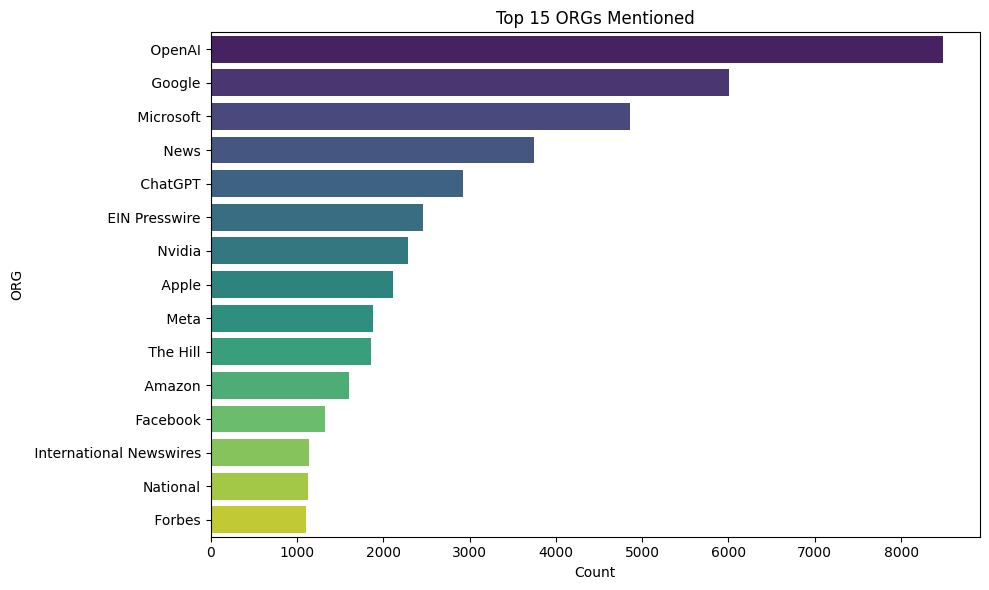

<ipython-input-66-19d4fd7ecdb2>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_freq.head(top_n), x="Count", y=column_name[:-1], palette="viridis")


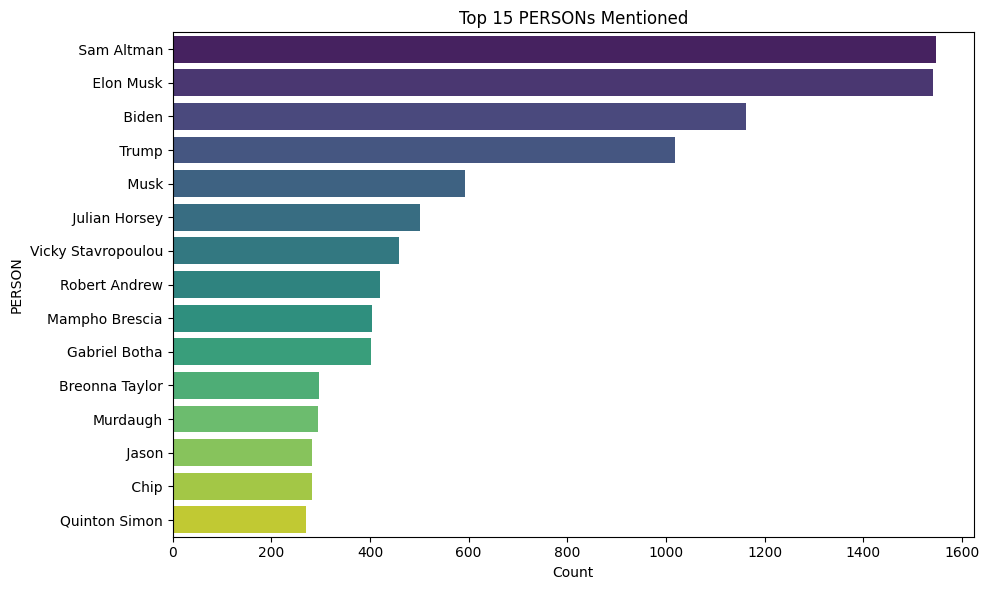

<ipython-input-66-19d4fd7ecdb2>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_freq.head(top_n), x="Count", y=column_name[:-1], palette="viridis")


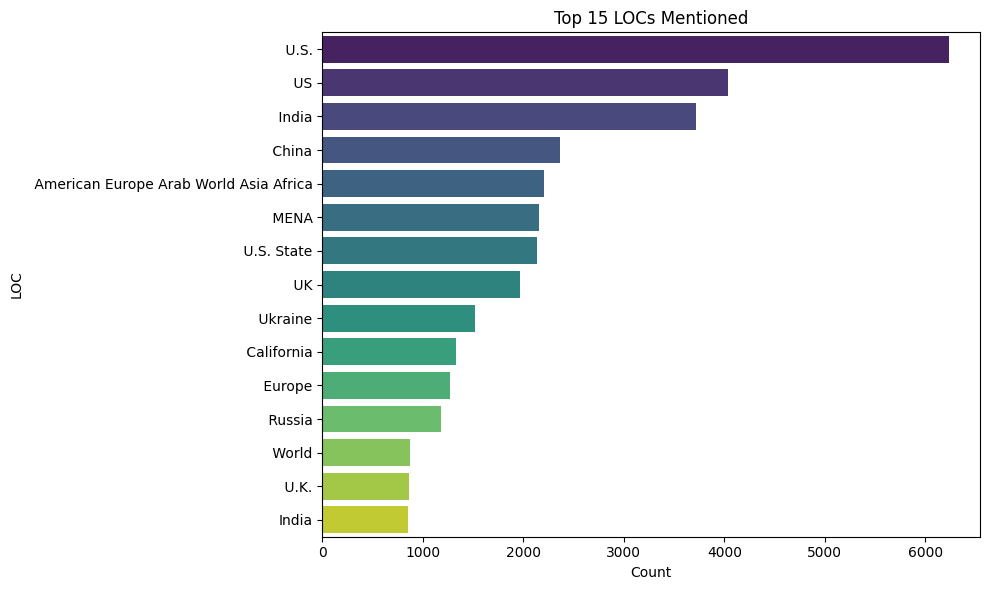

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import wandb

# Helper: plot + log for one entity type
def visualize_entity_frequency(df, column_name, top_n=15):
    # Flatten and count
    all_entities = [ent for row in df[column_name] for ent in row]
    entity_counts = Counter(all_entities)

    # Convert to DataFrame
    df_freq = pd.DataFrame(entity_counts.items(), columns=[column_name[:-1], "Count"]).sort_values("Count", ascending=False)

    # Log to wandb (top 10)
    wandb.log({f"top_{column_name.lower()}": wandb.Table(dataframe=df_freq.head(10))})

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_freq.head(top_n), x="Count", y=column_name[:-1], palette="viridis")
    plt.title(f"Top {top_n} {column_name} Mentioned")
    plt.tight_layout()
    plt.show()

# Run for each entity type
visualize_entity_frequency(df_ner, "ORGs")
visualize_entity_frequency(df_ner, "PERSONs")
visualize_entity_frequency(df_ner, "LOCs")

In [ ]:
df_ner

,url,date,language,title,text,text_cleaned,title_cleaned,doc,topic,sentiment_label,sentiment,ORGs,PERSONs,LOCs
0,http://businessnewsthisweek.com/business/infog...,2023-05-20,en,Infogain AI Business Solutions Now Available i...,\n\nInfogain AI Business Solutions Now Availab...,Infogain AI Business Solutions Now Available i...,Infogain AI Business Solutions Now Available i...,Infogain AI Business Solutions Now Available i...,1,LABEL_1,1,"[ GenY, Courtyard by Marriott Mahabaleshwar, ...","[ Fateh, Anubhav Sinha, Dibyendu Bhattachary...",[]
1,https://allafrica.com/stories/202504250184.html,2025-04-25,en,Africa: AI Policies in Africa - Lessons From G...,\nAfrica: AI Policies in Africa - Lessons From...,Africa: AI Policies in Africa - Lessons From G...,Africa: AI Policies in Africa - Lessons From G...,Africa: AI Policies in Africa - Lessons From G...,0,LABEL_1,1,"[ allAfrica, All, The Conversation Africa, ...",[ Thompson Gyedu Kwarkye],"[Johannesburg, Rwanda, Ghana, Africa]"
2,https://asiatimes.com/2023/07/yang-lan-intervi...,2023-07-25,en,Yang Lan interviews academics on AI developmen...,\nYang Lan interviews academics on AI developm...,Yang Lan interviews academics on AI developmen...,Yang Lan interviews academics on AI developmen...,Yang Lan interviews academics on AI developmen...,2,LABEL_1,1,"[ Asia Times, LinkedIn]","[ Yang Lan, Trump]","[ Philippines Southeast Asia, Asia, China Bu..."
3,https://cdn.meritalk.com/articles/commerce-nom...,2025-02-04,en,Commerce Nominee Promises Increased Domestic A...,\nCommerce Nominee Promises Increased Domestic...,Commerce Nominee Promises Increased Domestic A...,Commerce Nominee Promises Increased Domestic A...,Commerce Nominee Promises Increased Domestic A...,7,LABEL_1,1,"[ AI, Commerce, LinkedIn Twitter, Departmen...","[ Howard Lutnick, Donald Trump, Andrew Rice]",[]
4,https://citylife.capetown/hmn/uncategorized/re...,2023-11-11,en,Revolutionizing the Manufacturing Industry: Th...,Revolutionizing the Manufacturing Industry:...,Revolutionizing the Manufacturing Industry: Th...,Revolutionizing the Manufacturing Industry: Th...,Revolutionizing the Manufacturing Industry: Th...,0,LABEL_1,1,"[ Hla mus rau cov ntsiab lus, SpacetechnologyS...",[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147682,https://www.wkyt.com/prnewswire/2023/09/21/cha...,2023-09-21,en,"Chano Fernandez Joins Eightfold AI as Co-CEO, ...","Chano Fernandez Joins Eightfold AI as Co-CEO, ...","Chano Fernandez Joins Eightfold AI as Co-CEO, ...","Chano Fernandez Joins Eightfold AI as Co-CEO, ...","Chano Fernandez Joins Eightfold AI as Co-CEO, ...",14,LABEL_1,1,"[ Health DivideWKYT, Kentucky Newsmakers, WKYT...",[ Chano Fernandez],"[ Jude, Kentucky]"
147683,https://www.wncw.org/2024-11-16/biden-and-xi-t...,2024-11-17,en,Biden and Xi take a first step to limit AI and...,\n\nBiden and Xi take a first step to limit AI...,Biden and Xi take a first step to limit AI and...,Biden and Xi take a first step to limit AI and...,Biden and Xi take a first step to limit AI and...,12,LABEL_0,-1,[ WNCW],"[ Biden, Xi]",[]
147684,https://www.wndu.com/prnewswire/2023/11/15/woo...,2023-11-15,en,Woolpert and Allvision Forge Strategic Agreeme...,Woolpert and Allvision Forge Strategic Agreeme...,Woolpert and Allvision Forge Strategic Agreeme...,Woolpert and Allvision Forge Strategic Agreeme...,Woolpert and Allvision Forge Strategic Agreeme...,11,LABEL_1,1,"[En Español, SportsNotre DameEn Español, Wool...",[],"[North, Indiana]"
147685,https://www.wuwf.org/2024-06-03/all-eyes-on-ra...,2024-06-03,en,‘All eyes on Rafah’ is the Internet's most vir...,\n‘All eyes on Rafah’ is the Internet's most v...,‘All eyes on Rafah’ is the Internet's most vir...,‘All eyes on Rafah’ is the Internet's most vir...,‘All eyes on Rafah’ is the Internet's most vir...,12,LABEL_0,-1,"[ UWF, WUWF, WUW]",[],[ Rafah]


In [10]:
from collections import Counter
# Function to flatten and count
def count_entities(entity_list_column):
    all_entities = [entity for entities in df_ner[entity_list_column] for entity in entities]
    entity_counter = Counter(all_entities)
    df_entity = pd.DataFrame(entity_counter.items(), columns=["Entity", "Count"]).sort_values("Count", ascending=False)
    return df_entity

# ORGs
df_orgs = count_entities("ORGs")
print(f"Total ORG mentions: {df_orgs['Count'].sum()}")
print(f"Unique ORGs: {len(df_orgs)}")
print(df_orgs.head(10))

# PERSONs
df_persons = count_entities("PERSONs")
print(f"Total PERSON mentions: {df_persons['Count'].sum()}")
print(f"Unique PERSONs: {len(df_persons)}")
print(df_persons.head(10))

# LOCs
df_locs = count_entities("LOCs")
print(f"Total LOC mentions: {df_locs['Count'].sum()}")
print(f"Unique LOCs: {len(df_locs)}")
print(df_locs.head(10))


Total ORG mentions: 563699
Unique ORGs: 86119
             Entity  Count
103          OpenAI   8489
73           Google   6009
301       Microsoft   4860
144            News   3751
50          ChatGPT   2921
140   EIN Presswire   2466
89           Nvidia   2291
188           Apple   2114
95             Meta   1881
651        The Hill   1856
Total PERSON mentions: 62350
Unique PERSONs: 18332
                 Entity  Count
76           Sam Altman   1547
89            Elon Musk   1542
214               Biden   1162
7                 Trump   1019
97                 Musk    593
27        Julian Horsey    501
183  Vicky Stavropoulou    459
216       Robert Andrew    420
220      Mampho Brescia    404
218       Gabriel Botha    403
Total LOC mentions: 150874
Unique LOCs: 11598
                                      Entity  Count
15                                      U.S.   6232
20                                        US   4032
25                                     India   3721
7          

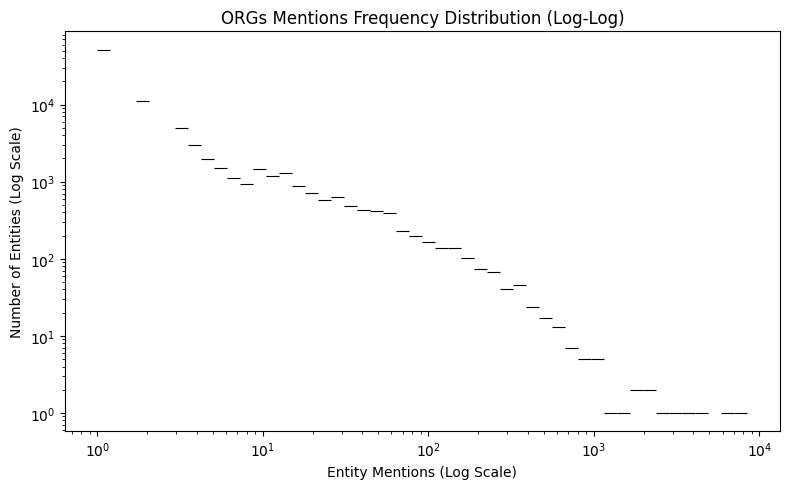

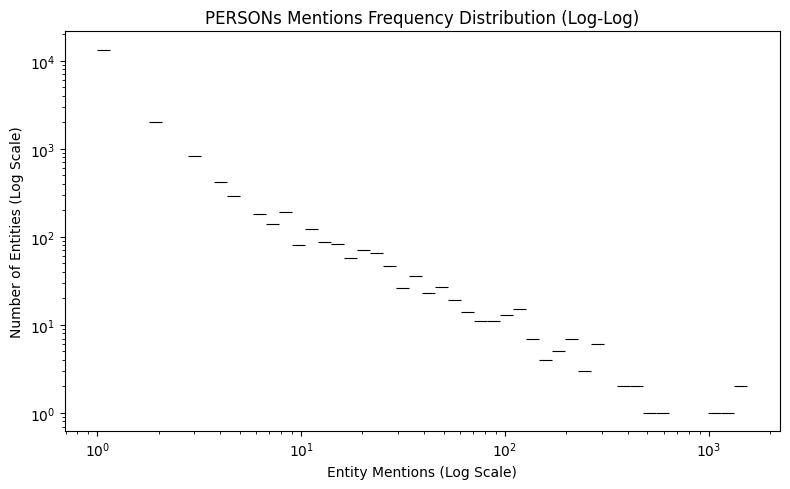

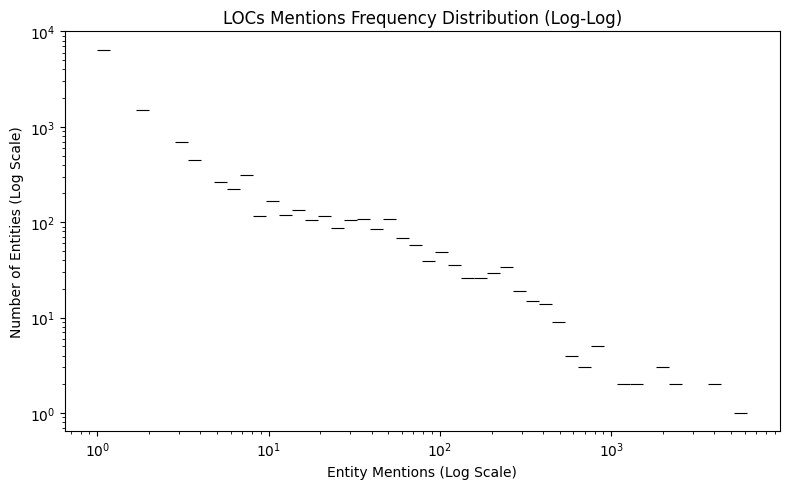

In [12]:
import numpy as np

def plot_entity_distribution(df_entity, title, color):
    plt.figure(figsize=(8, 5))
    sns.histplot(df_entity["Count"], bins=50, color=color, log_scale=(True, True))
    plt.title(f"{title} Mentions Frequency Distribution (Log-Log)")
    plt.xlabel("Entity Mentions (Log Scale)")
    plt.ylabel("Number of Entities (Log Scale)")
    plt.tight_layout()
    plt.show()

# ORG 分布
plot_entity_distribution(df_orgs, "ORGs", "blue")

# PERSON 分布
plot_entity_distribution(df_persons, "PERSONs", "green")

# LOC 分布
plot_entity_distribution(df_locs, "LOCs", "purple")

In [5]:
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

tqdm.pandas()

ai_keywords = [
    # Foundation Models
    "ChatGPT", "GPT-4", "GPT-3.5", "Claude", "Gemini", "Bard", "LLaMA", "Mistral", "Sora",
    # Tools and Frameworks
    "LangChain", "AutoGPT", "Agent", "RAG", "Vector Database", "Pinecone", "Weaviate",
    # Platforms
    "Copilot", "Notion AI", "Midjourney", "DALL·E", "Stable Diffusion", "Hugging Face",
    # Core Concepts
    "Transformer", "Self-Attention", "LoRA", "Fine-tuning", "RLHF", "DPO", "Tokenization",
    # Application Areas
    "AutoML", "RPA", "AI Ethics", "AI Regulation", "Synthetic Data", "Prompt Engineering",
    # Companies
    "OpenAI", "Anthropic", "Meta AI", "Google DeepMind", "Microsoft AI", "Stability AI"
]

def has_ai_tech(text):
    return any(keyword.lower() in text.lower() for keyword in ai_keywords)

print("🔍 Filtering news articles with AI technologies...")
df_ai_filtered = df_ner[df_ner["text_cleaned"].progress_apply(has_ai_tech)].copy()

print(f"✅ Done! {len(df_ai_filtered)} out of {len(df_ner)} articles mention AI-related technologies.")

🔍 Filtering news articles with AI technologies...


100%|██████████| 147687/147687 [02:27<00:00, 1001.14it/s]

✅ Done! 117188 out of 147687 articles mention AI-related technologies.


In [21]:
import gradio as gr
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import pandas as pd

def analyze_entity_sentiment_dual(entity_type="ORGs", quantile_threshold=0.9, top_n=10):
    entity_counter = defaultdict(int)
    for entity_list in df_ai_filtered[entity_type]:
        for entity in entity_list:
            entity_counter[entity] += 1

    entity_freq_series = pd.Series(entity_counter)
    threshold = entity_freq_series.quantile(quantile_threshold)

    entity_stats = defaultdict(lambda: {"count": 0, "pos": 0, "neg": 0, "sentiment_sum": 0})
    for _, row in df_ai_filtered.iterrows():
        sentiment = row["sentiment"]
        for entity in row[entity_type]:
            if entity_counter[entity] >= threshold:
                entity_stats[entity]["count"] += 1
                entity_stats[entity]["sentiment_sum"] += sentiment
                if sentiment > 0:
                    entity_stats[entity]["pos"] += 1
                elif sentiment < 0:
                    entity_stats[entity]["neg"] += 1

    df_entity_sentiment = pd.DataFrame([
        {
            entity_type[:-1]: entity,
            "Mentions": stat["count"],
            "Positive": stat["pos"],
            "Negative": stat["neg"],
            "Avg_Sentiment": round(stat["sentiment_sum"] / stat["count"], 3)
        }
        for entity, stat in entity_stats.items() if stat["count"] >= 2
    ])

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    if df_entity_sentiment.empty:
        for ax in axes:
            ax.text(0.5, 0.5, "No data found under current threshold", ha='center', va='center')
            ax.axis("off")
    else:
        df_pos = df_entity_sentiment[df_entity_sentiment["Avg_Sentiment"] > 0.2].sort_values("Mentions", ascending=False).head(top_n)
        barplot_pos = sns.barplot(data=df_pos, x="Mentions", y=entity_type[:-1], palette="crest", ax=axes[0])
        axes[0].set_title(f"Top {top_n} {entity_type[:-1]}s with Positive Sentiment (by Mentions)")
        for bar, sentiment in zip(barplot_pos.patches, df_pos["Avg_Sentiment"]):
            barplot_pos.annotate(f'{sentiment:.2f}',
                                 xy=(bar.get_width(), bar.get_y() + bar.get_height() / 2),
                                 xytext=(3, 0),
                                 textcoords="offset points",
                                 va='center', ha='left', fontsize=9)

        df_neg = df_entity_sentiment[df_entity_sentiment["Avg_Sentiment"] < -0.2].sort_values("Mentions", ascending=False).head(top_n)
        barplot_neg = sns.barplot(data=df_neg, x="Mentions", y=entity_type[:-1], palette="flare", ax=axes[1])
        axes[1].set_title(f"Top {top_n} {entity_type[:-1]}s with Negative Sentiment (by Mentions)")
        for bar, sentiment in zip(barplot_neg.patches, df_neg["Avg_Sentiment"]):
            barplot_neg.annotate(f'{sentiment:.2f}',
                                 xy=(bar.get_width(), bar.get_y() + bar.get_height() / 2),
                                 xytext=(3, 0),
                                 textcoords="offset points",
                                 va='center', ha='left', fontsize=9)

    plt.suptitle(f"{entity_type} Sentiment Analysis (Threshold: Top {int(quantile_threshold*100)}%)")
    plt.tight_layout()

    return plt

# Gradio interface
demo = gr.Interface(
    fn=analyze_entity_sentiment_dual,
    inputs=[
        gr.Dropdown(["ORGs", "PERSONs", "LOCs"], label="Entity Type", value="ORGs"),
        gr.Slider(0.5, 0.99, value=0.9, step=0.01, label="Threshold (Quantile)"),
        gr.Slider(5, 20, value=10, step=1, label="Top N Entities")
    ],
    outputs=gr.Plot(label="Entity Sentiment (Positive & Negative by Mentions)"),
    title="🔍 Dual View: Entity Sentiment Analysis (ORGs, PERSONs, LOCs - by Mentions with Sentiment Labels)"
)

demo.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4d9ea84bcf4096fe34.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
